# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 7:  Convolutional Neural Networks

**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Lab Team**: Eleni Kaxiras, Marios Mattheakis, Chris Gumb, and Shivas Jayaram<br/>
**Authors**: Cedric Flamant, Chris Gumb, Hayden Joy, Eleni Kaxiras, and Pavlos Protopapas
<br/>

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Objectives

By the end of this section, you should understand how images are represented in Python, have a strong understanding of the 'convolution' operation performed by CNNs, and be able to construct, train, and evaluate a CNN using Keras!

<a id="contents"></a>

## Notebook Contents
- [**Using SEAS Jupyter Hub**](#jubyterhub) {3 min}
- [**Working with Images in Python**](#images) {10 min)
    - [Image as Tensors](#tensors)
    - [An Image from Scratch](#imgfromscratch)
    - [Preprocessing: Padding](#pad)
    - [Preprocessing: Normalization](#norm) 
- [**An Implementation of "Convolution"**](#conv) {20 min}
    - [Setting Convolution Parameters](#params)
    - [Defining Filters: Kernels and Biases](#kernels)
    - [Calculating Output Dimensions](#outputdim)
    - [Convolution Implementation](#convloop)
    - [Multiple Convolution Layers](#mulilayer)
- [**Tensorflow Datasets**](#tfdatasets) {15 min}
    - [Loading Datasets](#loadds)
    - [The Dataset Object](#dsobj)
    - [Take, Cardinality, & Batch](#take)
    - [Cache, Prefetch, & Shuffle](#cache)
    - [Preprocessing with Datasets](#dspreproc)
    - [Data Augmentation](#dataaug)
- [**Keras**](#keras) {25 min}
    - [Layers of a CNN in Keras](#keras_layers)
    - [**Excercise:** Defining a Model](#keras_model)
    - [Training](#keras_train)
    - [Plotting Training History](#plottinghistory)
    - [Evaluating](#plottinghistory)
    - [Callbacks](#callbacks)
    - [**Exercise:** Improving on Baseline Model](#improving)
    

<a id='jupyterhub'></a>
## Using SEAS JupyterHub-GPU [^](#contents "Back to Contents")


<img src='fig/need-a-gpu.jpg' width='250px'>

**PLEASE READ**: [Instructions for Using SEAS JupyterHub](https://canvas.harvard.edu/courses/102556/pages/instructions-for-using-seas-jupyterhub)

SEAS and FAS are providing you with a Jupyter computing environment to use for your CS109B course work. It is accessible from 'JupyterHub-GPU' in the menu on the Canvas course page. The **GPU** available on these instances allow for much faster NN training. The libraries defined in <a href='https://canvas.harvard.edu/files/14521374/download?download_frd=1'>cs109b.yml</a> (keras, tensorflow, pandas, etc.) are all pre-installed.

**NOTE : This service funded by SEAS and FAS for the purposes of the class.**

**NOTE NOTE NOTE: You are only to use JupyterHub-GPU for purposes directly related to CS109B coursework.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it.**

In [4]:
# import sys
# !conda install -c conda-forge ipywidgets --yes
!conda install scipy

Solving environment: ...working... done

# All requested packages already installed.



In [7]:
import matplotlib.pyplot as plt
import numpy as np
# from scipy.signal import convolve2d, correlate2d
# from sklearn.datasets import load_sample_image
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import os
import random as rn

Error in sys.excepthook:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 1979, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'RuntimeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 1981, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "D:\Anaconda3\envs\cs109b\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "D:\Anaconda3\envs\cs109b\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "D:\Anaconda3\envs\cs109b\lib\site-packages\IPython\core\ultratb.py", line 851, in structured_traceback
    assert etb 

ImportError: SystemError: <built-in method __contains__ of dict object at 0x000002370FE25500> returned a result with an error set

<a id='images'></a>
## Working with Images in Python [^](#contents "Back to Contents")

Convolutional neural networks were developed for working with image data, having been inspiried by the study of biological vision\[[1](https://www.sciencedirect.com/science/article/pii/S187705091631674X)\]\[[2](https://arxiv.org/pdf/2001.07092.pdf)\]. Before we dive into CNNs themselves, we should first learn a bit about how images are represented digitally.

<div class='exercise' id='tensors'><b>Images as Tensors</b></div></br>



The `matplotlib.pyplot` module has several functions we can use to work with images in Python: [imread](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.pyplot.imread.html), [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), and [imsave](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imsave.html).<br>
Let's begin by loading an example image using `imread` and displaying it with `imshow`.<br>
(painting by [Mark Rothko](https://www.nga.gov/features/mark-rothko.html))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = plt.imread('data/rothko.jpg', )
plt.axis('off')
plt.imshow(img);

What more can we learn about this `img` object that we created by reading in our image file?

In [ ]:
print('Image Type:', type(img))
print('Image Shape:', img.shape)
print('Array Type:', img.dtype)
print(f'Value Range: [{img.min()}, {img.max()}]')

The image is represented as a 3-dimensional numpy array, or **tensor**. The 1st dimension is height, the 2nd is width, and the 3rd is the **color channel**.

Each element, or pixel, in the array is an 8-bit, unsigned integer. $2^8 = 256$ so a pixel can take on values from 0 and 255. <br />
Because the images a numpy array we can use familiar Python indexing to specify certain sections.<br>
Let's explore the image's color channels. 

In [ ]:
tf.__version__

In [ ]:
fig, axs = plt.subplots(1, 3)
rgb_list = ['Reds', 'Greens', 'Blues']

for i, ax in enumerate(axs.ravel()):
    ax.imshow(img[:,:,i], cmap=rgb_list[i])
    ax.axis('off')
    ax.set_title(rgb_list[i])
    plt.tight_layout()

When we pass a tensor with 3 channels to `imshow` it assumes these are <span style='color: red'>red</span>,  <span style='color: green'>green</span>, and  <span style='color: blue'>blue</span>.<br>
However, for inputs with a different number of channels we need to use the [**cmap**](https://matplotlib.org/stable/tutorials/colors/colormaps.html) argument to specify the color gradient to map the pixel values onto. For example, there is nothing *intrinsically green* about the 2nd color channel plucked from our original image. It's just a 2-D array of integers where each integer represents the *intensity* of the pixel, but it contains no information about the color. If we want `imshow` to interpret it as green, or any other color, then we need to make that explicit.

**Note:** Some image formats such as png can have a 4th channel referred to as **alpha** which controls transparency. `imshow` knows how to handle these 4-channel images, but it is important to keep this in mind lest the extra channel catch you by surprise.

<div class='exercise' id='imgfromscratch'><b>An Image from Scratch</b></div></br>

We can use what we now know about an image's digital representation to build an image from scratch by creating and manipulating a `numpy` array.

Let's create a 5x5 RGB image made from scratch using `numpy` and call it `toy_img`.
* The <span style='color:red'>red</span> channel will contain a diagonal line starting in the upper right corner <span style='color:red'><strong>\\</strong></span>
* The <span style='color:green'>green</span> channel will contain a 'backwards' diagonal line starting in the lower right corner <span style='color:green'>**/**</span>
* The <span style='color:blue'>blue</span> channel will have a vertical line in the middle of the image <span style='color:blue'>**|**</span>

To keep it simple, all pixels in each channel will be either fully on or off<br>
We'll use `1` for all the 'on' pixels and `0` for 'off' pixels.<br>

* `np.zeros()` can create an image of all 'off' pixels; we can then 'turn some on' using slicing/indexing
* `np.eye(N)` creates an identity NxN matrix 
* `np.flipud(a)` flips the array `a` upsidedown

In [ ]:
toy_img = np.zeros((5,5,3)) # blank image of all 'off' pixels
# RED
toy_img[:,:,0] = np.eye(5) # diagonal of red
# GREEN
toy_img[:,:,1] = np.flipud(np.eye(5)) # backwards diagonal of green
# BLUE
toy_img[:,2,2] = 1 # vertical line of blue in the middle
plt.imshow(toy_img);

Looking good! Note how the center pixel where all 3 channels are set to `1` is white.<br> 
But if we are thinking of `toy_img` as a 3-channel image then something unintuitive happens when we try and display the image as a 3d numpy array (i.e., tensor).

In [ ]:
# Display 5x5x3 toy image tensor
toy_img

What's going on here! We see 5 matrices, each 5x3. It is hard to tell by looking at this just what is going on in each color channel.<br>
The problem is that numpy is splitting the display based on the first dimension (by row). You can think of this as treating the first dimension as though _that_ were the channel.<br>
But, as long as we are thinking about this tensor as an an image with the last diemension specifying the color channel, we would prefer to split the display by this last dimension.<br>
The `show_channels()` helper function does just that by swaping the first and last axes in the tensor and then printing the result.

In [ ]:
# Helper function to display image tensor split into color channels
def show_channels(tensor):
    channel_first= np.rollaxis(tensor, 2, 0)
    return(channel_first)

In [ ]:
# Display color channels as matrices
show_channels(toy_img)

Now we can clearly see our 3 color channels.

<div class='exercise' id='pad'><b>Preprocessing: Padding</b></div></br>

Most networks you'll encounter expect **inputs of a fixed dimension**. This can make life difficult if you want to train your CNN on a set of images of varying sizes. One solution would be to **crop** all images down to the same size, but this forces us to throw away what could be useful information.<br>
A more palatable option is to **pad** our images by adding a border of zeros.<br>

Previously, in CS109A, we learned how to add a column of ones to our NN's input design matrix with `np.ones()`. This allowed for multiplication with the bias terms during the forward pass. We could use a similar approach to add a padding of zeros around our image using `np.zeros` but that would be tedious! Luckily there is `np.pad()`:<br> [https://numpy.org/doc/stable/reference/generated/numpy.pad.html](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)<br>
But the use of this function can be a bit confusing at first, especially if you want to vary the amount of padding on each side of the image, or if you are working with higher dimensional tensors.<br>

First, let's practice by creating a 3x3 matrix of ones and give it a padding of 2 on all sides.

In [ ]:
# original
a = np.ones((3,3))
a

In [ ]:
# padded
np.pad(a, 2)

Now for some more complicated padding:
* 1 padding on top
* 2 padding at bottom
* 3 padding on left
* 4 padding on right

Display the resulting matrix

**Note:** Don't forget to look at the `np.pad()` documentation, **either with `Shift+Tab` in Jupyter**, or by following link above.
The `pad_width` argument takes a $n$-tuple of 2-tuples, where $n$ is the number of dimensions and the 2-tuples describe how much padding to add to the beginning and end of that dimension.<br>
So in this case our `pad_width` looks like `((top, bottom), (left, right))`

In [ ]:
# padding a 2-D array
np.pad(a, pad_width=((1,2),(3,4)))

Now we add the same padding above to `toy_img` and store the result in `toy_img_pad`.

**Note:** Consider the dimensions of `toy_img`. We need another 2-tuple for the channel dimension, but we wouldn't want to pad *this* dimension!

In [ ]:
# padding a 3-D tensor
toy_img_pad = np.pad(toy_img, ((1, 2), (3, 4), (0,0)))

In [ ]:
# display the tensor by channel
show_channels(toy_img_pad)

In [ ]:
# display as an image
plt.imshow(toy_img_pad);

<div class='exercise' id='norm'><b>Preprocessing: Normalizing</b></div></br>

If we're going to be using our images as input to a neural network we should normalize all pixel values to between 0 and 1. This helps our gradients 'well behaved.'

We saw earlier that the pixels are unsigned 8-bit integers and so can take on values between 0 and 255. Now that we know the max possible value normalization is easy. We simply divide the tensor representing the image by 255!

`imgshow()` is clever enough to display normalized images exaclty the same as it displays the unnormalized version.

In [ ]:
img_norm = img/255.
fig, axs = plt.subplots(1,2)
for ax, image, title in zip(axs, [img, img_norm], ['unnormalized', 'normalized']):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

We can take what we've learned to make a 'forgery' of the original Rothko painting! 🤖🎨🖌️ 🖼️

In [ ]:
# our blank 'canvas' of black (i.e., zeros)
rothko2 = np.zeros((8,5,3))
# some red horizontal lines
rothko2[:3,:,0] = 1
# some green
rothko2[4,:,:2] = 1
# and some blue
rothko2[6:,:,1:] = 1
# add a black border
rothko2 = np.pad(rothko2,((1,1),(1,1),(0,0)))
# And voilà!
plt.imshow(rothko2);

Not too bad! And we see just what we'd expect when view the individual color channels.

In [ ]:
fig, axs = plt.subplots(1,3)
rgb_list = ['Reds','Greens','Blues']
for i, ax in enumerate(axs.ravel()):
    ax.imshow(rothko2[:,:,i], cmap=rgb_list[i])
    ax.axis('off')
    ax.set_title(rgb_list[i])

In [ ]:
show_channels(rothko2)

Finally, let's save our work as a PNG for posterity with `imgsave` and ensure that we've done so correctly by reading and displaying it again.

In [ ]:
plt.imsave('data/rothko2.png', rothko2, vmin=0, vmax=1, format='PNG')
test_load = plt.imread('data/rothko2.png')
plt.imshow(test_load);

But what do we see if we inspect the representation of the loaded PNG? It's that tricky 4th "color" channel, alpha!

In [ ]:
show_channels(test_load)

<a id='conv'></a>
## An Implementation of "Convolution" [^](#contents "Back to Contents")

<img src='fig/conv_op1.png' width='1000px'>

A convolutional layer is composed of **filters** which are composed of **kernels** which are *themselves* composed of **weights**. Each filter also has a **bias** term though it is often not depicted in diagrams (it is exluded in the one above for example). We *learn* the weights and biases from our data. Each conv layer also has an associated **activation function** such as ReLU or sigmoid. 

In Keras, the **number of filters** and the **height and width of the kernels** of which they consist are set by the `filters` (int) and `kernel_size` (int or tuple) arguments respectively. 

The **depth of the filters is fixed** by the depth (i.e., number of 'channels' or 'filter maps') of the input to the conv layer. 

The output of the conv layer, if we have multiple filters, is a 3D tensor which is a set of **feature maps**. Each feature map is itself the output of one of the layer's filters "convolving" on the input. The height and width of the output feature map tensor is a function of the input size, `kernel_size`, `padding`, and `stride`. The depth of the output tensor (i.e, number of feature maps) is equal to the number of `filters` in the layer.

The best way to build intuition for what the covolution layers in Keras are (roughly) doing is to step through a basic implementation of our own.<br>
We'll construct a basic implementation and explore the affect of some different filters and parameters on the output.

For this section we'll use this lovely photograph of a pagoda that comes with `sklearn`.

In [ ]:
from sklearn.datasets import load_sample_image
# normalized image
img = load_sample_image('china.jpg')/255.
plt.axis('off')
plt.imshow(img);

In [ ]:
fig, axs = plt.subplots(1,3)
rgb_list = ['Reds','Greens','Blues']
for i, ax in enumerate(axs.ravel()):
    ax.imshow(img[:,:,i], cmap=rgb_list[i])
    ax.axis('off')
    ax.set_title(rgb_list[i])

<div class='exercise' id='params'><b>Convolution Parameters</b></div></br>

We'll need to set some basic parameters for our convolution.


**Number of Filters**: determines the number of output feature maps 

**Kernel Dimensions**: height and width of the filters (depth determined by input depth)

**Padding**: extra pixels added to the border of the input. Typically these are zeros. Common paddings settings are 'valid' ('valid' padding means no padding at all and differs from 'full' padding), full padding, which ensures every pixel of the input is visited the same number of times by the filter, and 'same' which ensures the output is the same size (height and width) as the input.

<img src='fig/padding.png' width='500px'>

**Stride**: how large of a 'step' the filter takes when convolving.

<img src='fig/stride.png' width='400px'>


Almost anything will work here and we can come back to play with these values later. But let's start simple.

In [ ]:
# basic convolution parameters
n_filters = 3 # number of filters (each producing a feature map)
k_dim = (3,3) # kernel height and width
padding = 1 # zeros to add around border
strides = 1 # size of step when convolving

<div class='exercise' id='kernels'><b>Defining Filters: Kernels and Biases</b></div></br>


We will store the weights of our filters in a 4D tensor (which is also how Keras stores the weights in its Conv2D layers as we'll see later). We'll call our weight tensor `filters`.<br>
The dimensions are: (number of filters) x (kernel height) x (kernel width) x (filter depth)<br>

For our example, `filters` will contain 3 identical filters, each composed of 3 identical kernels, and the values in each filter will sum to 1.<br>

Each filter also has a bias term. We'll create `biases` to be a numpy array of zeros (you can also try changing it later to see what affect it has).

In [ ]:
# filters is a 4D tensor
# Number of filters x kernel height x kernel width x filter depth
filters = np.ones((n_filters, *k_dim, img.shape[-1]))/np.prod([*k_dim, img.shape[-1]])

# biases is a 1d array; there is one bias for each filter
biases = np.zeros(n_filters)

**Q:** Why is it important that the weights in each kernel sum to one? What would happen if they are larger or smaller? 🤔

**Q:** Why might we want 3 identical filters here? 🤔 

<div class='exercise' id='outputdim'><b>Calculating Output Dimensions</b></div></br>

Calculating the output dimensions based on our input image and parameters will be essential for implementing convolution. The function should throw an error if the dimensions are not integers.<br>
We can refer to the equation:

$$O = \frac{W - K + 2P}{S} + 1$$
Where $O$ is the output dim, $W$ is the input dim, $K$ is the filter size, $P$ is padding, and $S$ is the stride.

In [ ]:
# Calculates output shape based on input and conv parameters
def output_dim(img: np.array, filters: np.array, padding: int, strides: int):
    w = np.array(img.shape[:-1])
    k = filters[0].shape[:-1]
    out_dim = (w - k + 2*padding)/strides + 1
    assert (out_dim % 1).all() == 0, "Calculated output dimensions not integer valued"
    return out_dim.astype(int)

In [ ]:
out_dim = output_dim(img, filters, padding, strides)
out_dim

<div class='exercise' id='convloop'><b>"Convolution"</b></div></br>
<img src='fig/convolve.gif' width='200px'>
Here we'll implement the "convolution" (as that term is used in CNNs) algorithm as a function.<br>

We'll make use of `out_dim` and what we learned about `np.pad`. We won't implement 'valid' or 'same' padding, only a uniform amount of padding provided to all sides of the input image.

In [ ]:
img.shape

In [ ]:
def convolution(img, filters, biases=None, padding=1, strides=1):
    # pad input image
    img = np.pad(img, ((padding, padding), (padding, padding), (0,0)))
    # get new input dimensions after padding
    input_dim = np.array(img.shape)
    # determine output dimensions 
    filter_map_dim = output_dim(img, filters, padding, strides)
    # find dimensions of individual filter
    k_dim = filters.shape[1:]
    # if no biases specified, set them to zero (num biases == num filters)
    if biases is None:
        biases = np.zeros(filters.shape[0])
    
    # create empty array to store the convolution results 
    filter_maps = np.ones(shape=(*filter_map_dim, len(filters)))
    # loop over filters
    for f in range(filters.shape[0]):
        # init y pos of upper left corner of filter on input image to 0
        input_y = filter_maps_y = 0
        # loop over rows until we run off the bottom
        while input_y + k_dim[0] <= input_dim[0]:
            # init x pos of upper left corner of filter on input image to 0 
            input_x = filter_maps_x = 0
            # loop over columns until we run off the side
            while input_x + k_dim[1] <= input_dim[1]:
                # x & y coordinates of input that filter currently 'sees'
                xs = slice(input_x, input_x + k_dim[0])
                ys = slice(input_y, input_y + k_dim[1])
                # elementwise multiplication, add bias, sum, and store in output
                filter_maps[filter_maps_y, filter_maps_x, f] = np.sum(img[ys, xs, :] * filters[f]) + biases[f]
                # advance column based on stride
                input_x += strides
                # NOTE: movement over output img NOT based on stride!
                filter_maps_x += 1
            # advance row based on stride
            input_y += strides
            # NOTE: movement over output img NOT based on stride!
            filter_maps_y += 1
    return filter_maps

In [ ]:
%%time
out = convolution(img, filters, biases, padding, strides)

def show_result(img, out):
    fig, axs = plt.subplots(1,2, figsize=(20,20))
    out = np.clip(out, 0., 1.)
    imgs = [img, out]
    titles = ['original', 'output']
    for i, title in enumerate(titles):
        for spine in axs[i].spines.values():
            spine.set_visible(False)
        axs[i].imshow(imgs[i])
        axs[i].set_title(title)

show_result(img, out)

We can experiment with different values for the stride and padding and seeing how this affects the output.<br>
You can also go back and change `k_dim` and rerun all the following cells to see how larger/smaller kernels affect the output.

In [ ]:
%%time
# CONFIGURE CONV HERE
n_filters = 4 # number of filters (each producing a feature map)
k_dim = (3,3) # kernel height and width
padding = 1 # zeros to add around border
strides = 1 # size of step when convolving

filters = np.ones((n_filters, *k_dim, img.shape[-1]))/np.prod([*k_dim, img.shape[-1]])
biases = np.zeros(n_filters)
out = convolution(img, filters, biases, padding, strides)
show_result(img, out)

**Q:** Why is the resulting image black & white? 🤔 <br>
**Hint:** Consider the operation that takes place when were are calculating each pixel value of the output image and think back to the white pixel in the `toy_image` we made earlier. 

For variety, we'll make a copy of `kernels` using `np.copy()` and save it as `new_kernels`. Scale down the values in each kernels in `new_kernels` by a different value for each kernel. Now rerun the convolution. How does this affect the output image? Is it still black & white? If not, what else is wrong?

In [ ]:
# your code here
new_filters = filters.copy()
new_filters[0] *= 0.8
new_filters[1] *= 0.5
new_filters[2] *= 0.3

In [ ]:
out2 = convolution(img, new_filters, biases)

In [ ]:
show_result(img, out2)

<div class='exercise'><b>Sharpen Filter & Polychromatic Output</b></div></br>

Now we'll create a 3D filter from the provided 2D `sharp_kernel` that will only affect the red color channel and save it as `filter_R`.
**Hint:** `np.pad()` and `np.reshape()` may be useful.

In [ ]:
sharp_kernel = np.array([[ 0.,-1., 0.],
                         [-1., 5.,-1.],
                         [ 0.,-1., 0.]])

In [ ]:
filter_R = np.pad(sharp_kernel.reshape(*sharp_kernel.shape,-1), ((0,0), (0,0), (0,2)))
filter_R.shape

In [ ]:
show_channels(filter_R)

Again using `sharp_filter` as a starting point, use a loop to create a 4D tensor `sharp_filters` where each kernel only operates on one of the 3 color channels.

In [ ]:
sharp_filters = np.zeros((n_filters, *sharp_kernel.shape, img.shape[-1]))
for i in range(sharp_filters.shape[-1]):
    sharp_filters[i,:,:,i] = sharp_kernel

In [ ]:
for i, color in enumerate(['red', 'green', 'blue']):
    print(color)
    print(show_channels(sharp_filters[i]))
    print()

Now run the convolution again using your new sharp filters.

In [ ]:
out_sharp = convolution(img, sharp_filters)

In [ ]:
show_result(img, out_sharp)

Later, on your own, you should also try experimenting with how altering parameters like kernel size and stride can affect the output image when using the sharpen filter.

<div class='exercise' id='mulilayer'><b>Multiple Convolution Layers</b></div></br>

<img src='fig/cnn2.png' width='700px'>

The true power of CNNs comes from their 'deep' architecture. That is, when we stack convolution operations one after the other with the output **feature maps** of one convolutional 'layer' serving as the input to the next convolutional layer.

In this next example we'll do just that. Creating a **2 layer CNN** and inspecting the feature map we get at as output from the second layer.<br>

If each layer can be though of as learning certain features of the image, then layers deeper in the network are learning more complex and abstract features: features of features! 🤯

We'll use a picture of <a href="https://en.wikipedia.org/wiki/Widener_Library">Harvard's Widener Library</a> as our input image:

In [ ]:
img = plt.imread("data/Widener_Library.jpg")
# normalize
img = img/255.
plt.imshow(img);

In [ ]:
img.shape

### 1st CNN Layer

<img src='fig/conv-many-filters.png' width='550px'>

Our first CNN layer will consist of **2 3x3x3 filters**: one for **vertical edge detection** and another for **horizontal edge detection**.<br>Each filter is composed of 3 identical 3x3 kernels, one for each of the input image's color channels.<br>
(see https://en.wikipedia.org/wiki/Kernel_(image_processing) for kernel examples)

We apply each filter to the input image like a CNN would:
1. Convolution 
2. Add Bias
3. Activation Function

We'll use the **ReLU activation function** where $\textrm{ReLU}(x) = \textrm{max}(0,x)$

In [ ]:
def relu(x):
    return np.clip(x, a_min=0., a_max=None)

x = np.linspace(-1,1)
plt.plot(x, relu(x))
plt.title('ReLU Activation');

In [ ]:
from scipy.signal import convolve2d, correlate2d

Let's use the **vertical edge detection** filter first, saving the resulting **feature map** as `vedges`.

**Implementation Notes:**
- The version of convolution we implemented in the previous section may served to illustrate the operation, but with its nested loop structure it is far from efficient. For the following section we'll use [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) for our convolution. 
- `mode='same'` pads the input to ensure the output has the same height and width.
- Because all the kernels in the filter are identical, we can just define one kernel and convolve it over each color channel in turn.
- We are adding a bias of 0 which has no effect. We only include it to replicate the operations of a CNN layer.

In [ ]:
# Apply a Vertical Edge detection filter
vedge_kernel = np.array( [[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])/3.
# to store our output feature map
vedges = np.zeros_like(img)
# elementwise multiplication
for i in range(3):
    # vedges[:,:,i] = convolve2d(img[:,:,i], vedge_kernel, mode='same')
    vedges[:,:,i] = correlate2d(img[:,:,i], vedge_kernel, mode='same')
# sum results across channels, producing a flat feature map
vedges = vedges.sum(-1)
# add a bias 
bias = 0
vedges += bias
# ReLu activation
vedges = relu(vedges)

We then perform the same operation with the **horizontal edge filter** on `img`, saving the resulting **feature map** as `hedges`.

In [ ]:
# Apply a Horizontal Edge detection filter
hedge_kernel = np.array( [[ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1]])/3.
hedges = np.zeros_like(img)
for i in range(3):
    # hedges[:,:,i] = convolve2d(img[:,:,i], hedge_kernel, mode='same')
    hedges[:,:,i] = correlate2d(img[:,:,i], hedge_kernel, mode='same')
hedges = hedges.sum(-1)
bias = 0
vedges += bias
hedges = relu(hedges)

Finally we visualize the two feature maps.<br>
We'll show them in black & white by setting `cmap='gray'` in our call to `imshow`. This is just convention; we could use any color map we like.

In [ ]:
# visualize the 2 feature maps
fontsize = 20
f, ax = plt.subplots(1,2, figsize=(13,8))
ax[0].imshow(np.clip(vedges,a_min=None, a_max=1.), cmap='gray')
ax[0].set_title('Vertical Edge Detection', {'fontsize': fontsize})
ax[0].axis('off')
ax[1].imshow(np.clip(hedges, a_min=None, a_max=1.), cmap='gray')
ax[1].set_title('Horizontal Edge Detection', {'fontsize': fontsize})
ax[1].axis('off')
plt.tight_layout()

### 2nd CNN Layer
Together, `vedges` and `hedges` could be the output of the first layer of a CNN with 2 filters. Now we will investigate what can happen when we stack convolution layers. 

To achieve this, we'll concatenate `vedges` and `hedges` in a third dimension, calling the output `feature_maps`. `feature_maps` should have dimensions (267, 400, 2).

In [ ]:
# Concatenate the feature maps
feature_maps = np.concatenate((np.expand_dims(vedges, axis=-1), np.expand_dims(hedges,axis=-1)), axis=-1)
print('Feature Map Shape:', feature_maps.shape)

Now we take the following 3x3x2 identity filter $A_{ijk}$:
$$
A_{:,:,1} = A_{:,:,2} =  \left( \begin{array}{ccc}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 \\
\end{array} \right),
$$
and apply it to `feature_maps`. This time, we will use a bias of -2 as it produces a nice contrast in the final image. We then pass result through a ReLU, saving the output in variable `outmap`. 

In [ ]:
# convolve to produce output of 2nd CNN layer
corner_kernel = np.array([[[0,0,0],
                           [0,1,0],
                           [0,0,0]],
                          [[0,0,0],
                           [0,1,0],
                           [0,0,0]]])
outmap = np.zeros(feature_maps.shape[:2])
for i in range(2):
    # outmap[:,:] += convolve2d(feature_maps[:,:,i], corner_kernel[:,:,i], mode='same')
    outmap[:,:] += correlate2d(feature_maps[:,:,i], corner_kernel[:,:,i], mode='same')
bias = -2
outmap += bias
outmap = relu(outmap)

Now that the image has passed through 2 CNN layers.<br>
Before visualizing you results, what do expect to see? What would you call the kind of feature represented in our final output feature map? (Think about the input feature maps and what our final CNN layer is doing.)

In [ ]:
# plot output of 2nd CNN layer
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.imshow(np.clip(outmap, a_min=0, a_max=1.), cmap='gray')
ax.set_title('What Might This Feature Be?', {'fontsize': fontsize})
ax.axis('off')
plt.tight_layout()

<a id='tfdatasets'></a>

## Tensorflow Datasets [^](#contents "Back to Contents")
<img src='https://3.bp.blogspot.com/-d-nV7xJRmpw/Xo328dcAx3I/AAAAAAAAC7Q/qlqJOle6XIosJ3CGIDJ04F3Voh1iXDg0gCLcBGAsYHQ/s1600/TF_FullColor_Icon.jpg' width='150'>

TensorFlow Datasets (TFDS) is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks. These datasets are exposed as `tf.data.Dataset` objects, enabling easy-to-use and high-performance input pipelines.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

To improve TensorFlow's performance in our current environment we can run the following commands. Don't fret too much over what all these commands are doing. There are links in the comments if you'd like to learn more.

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs
tf.compat.v1.enable_eager_execution()

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

<div id="loadds" class='exercise'><b>Loading Datasets</b></div></br>

TFDS gives us access to dozens of research quality datasets with the simple `tfds.load` method.<br>
An extensive catalogue of datasets can be seen <a href='https://www.tensorflow.org/datasets/catalog/overview'>here</a>. You can even <a href='https://www.tensorflow.org/datasets/add_dataset'>write your own custom dataset</a>.

### <div style='font-size: 150%'>🐎 or 🧍?</div>

But it doesn't mean you should just because you can. The *bizzare* <a href='http://laurencemoroney.com/horses-or-humans-dataset'>Horses or Humans</a> dataset may just be an example of this.<br>
Our call to `tfds.load` will use several arguments:
- `name`: (str) the dataset to load (you can look these up in the above catalogue)
- `split`: (list) some datasets have pre-specified splits; this list defines which splits to load
- `shuffle_files`: (bool) files are loaded in random order
- `as_supervised`: (bool) loads labels if dataset has them
- `with_info`: (bool) also returns an DatasetInfo object with details about the loaded dataset


In [ ]:
# tfds.enable_progress_bar()
tfds.disable_progress_bar()

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(name="horses_or_humans", split=['train', 'test'],
                                         shuffle_files=True, as_supervised=True, with_info=True, )

The `ds_info` we got from using `with_info=True` gives us a great overview of some facts about the dataset.

In [ ]:
ds_info

<div id="dsobj" class='exercise'><b>The Dataset Object</b></div></br>

We'll be working with closely with the `tf.data.Dataset` object so we should learn more about its methods and structure.

**Some Python Arcana: Iterables & Iterators**:<br>

The `tf.data.Dataset` object is an *iterable*, which means it implements an `__iter__` method which returns an *iterator* object.<br>
An *iterator* is an object that implements a `__next__` method which returns the next element in the iterator!

In [ ]:
# create iterator from iterable
my_iter = iter(ds_train)
my_iter

In [ ]:
# get next element from iterator
next_one = next(my_iter)
print(f'Each element in the iterator is of type {type(next_one)} with length {len(next_one)}')

In [ ]:
# display element from iterator
next_one

Inspecting this tuple we see the 1st element is our image and the 2nd is the lable. Let's visualize the image.

In [ ]:
image, label = next_one
plt.imshow(image)
plt.title(int(label));

It appears humans are the positive class. Let's make a dictionary to map class labels to strings.

In [ ]:
# create human interperatable class names
class_names = {0: 'horse', 1: 'human'}

**Iterating**

Iterables can be looped over with a `for` loop. And while you *can* loop over the `Dataset` iterable object itself it is more common to first use the `as_numpy_iterator()` method if running TF in eager mode.

In [ ]:
rows = 3
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(10,6))
for ax, (img, label) in zip(ax.ravel(), ds_train.as_numpy_iterator()):
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(img)
    ax.set_title(class_names[label])
    ax.axis('off')

The above method works, but it would be a nuisance to have to always write out all that code just to inspect our datasets.

Luckily, `tfds` has a much faster way to do this with the `show_examples()` method.

In [ ]:
# train examples
tfds.show_examples(ds_train, ds_info, rows=rows, cols=cols);

In [ ]:
# test examples
tfds.show_examples(ds_test, ds_info, rows=rows, cols=cols);

**Q:** Do you notice anything strange about the test examples? 🤔

<div id="take" class='exercise'><b>Take, Cardinality, & Batch</b></div></br>

**Take**

We can use the `take()` method to return a **subset** of the original `Dataset` object of a desired **cardinality**.

In [ ]:
# get a subset with cardinality 2
my_subset = ds_train.take(2)

**Cardinality**

It's true that we can check the length of a datset with `len()`

In [ ]:
# one way to find a Dataset's length
len(my_subset)

But this is inefficient  for larger datasets.<br>
It is preferable to use the `cardinality()` method. This returns a Tensor.

In [ ]:
# a better way
cardinality = my_subset.cardinality()
print(f'Cardinality Type: {type(cardinality)}')

It looks a bit strange when displayed.

In [ ]:
# displaying an EagerTensor
cardinality

But it behaves just like an integer.

In [ ]:
# no surprises here!
(cardinality + 2) == 4

And if you really want to, you can always convert it to a `numpy.int64` object which prints nicely.

In [ ]:
# convert to nump.int64
cardinality.numpy()

**Batch**

To get the benefits of <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>**stochastic gradient descent**</a> (SGD) during training, we'd like to feed elements from the dataset into our model in batches.<br>
This is handled by the `batch()` method.

**Q:** What are some benefits of SGD? 🤔

In [ ]:
BATCH_SIZE = 32
num_batch = ds_train.cardinality() / BATCH_SIZE
print(f'Number of Potential Batches of size {BATCH_SIZE}:', num_batch.numpy())
num_batched_produced = ds_train.batch(BATCH_SIZE).cardinality()
print(f'Number of Batches of size {BATCH_SIZE} Produced:', num_batched_produced.numpy())

**Q:** Why don't these numbers match? What's going on? 🤔

The batched dataset is itself a `Dataset`, but now it's an iterable that produces batches.<br>
In a **supervised** situation like ours, each batch is a tuple.

In [ ]:
# inspect first batch
my_batch = ds_train.batch(BATCH_SIZE).as_numpy_iterator().next()
print(f'Each batch is of type {type(my_batch)} with length {len(my_batch)}')

The 1st element of the tuple are all the images in the batch.

In [ ]:
# batch images
my_batch[0].shape

The 2nd element are all the labels in the batch.

In [ ]:
# batch labels
my_batch[1].shape

**Note:** The batch of images and labels above are both `numpy` arrays. This is because we used `as_numpy_iterator()` on our batched dataset. This is why we were able to use the `shape` attribute. here.

We can also strengthen our intuition about the structure of the batched dataset by iterating over the batches and displaying the first image in each.

In [ ]:
# display the first image in each batch
fig, axs = plt.subplots(4, 8, figsize=(9,5))
axs = axs.ravel()
for i, (img_batch, label_batch) in enumerate(ds_train.batch(BATCH_SIZE, drop_remainder=True)):
    for (img, label) in zip(img_batch, label_batch):
        axs[i].imshow(img)
        axs[i].set_title(f'batch {i+1}')
        axs[i].axis('off')
        break
plt.tight_layout()

<div id="cache" class='exercise'><b>Cache, Prefetch & Shuffle</b></div></br>

There are helpful methods we can use to optimize the training process. Most of these descriptions are adapted from the TensorFlow documentation. As always, the documentation is the best place to go if you'd like a deeper understanding.

**<a href="https://www.tensorflow.org/guide/data_performance#caching">`Cache`</a>** caches a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. (perhaps not a good idea for enormous datasets)

**`Prefetching`** overlaps the preprocessing and model execution of a training step. While the model is executing training steps, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data."

**<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle">`Shuffle`</a>** Randomly shuffles the elements of this dataset.

**Note:** cache will produce exactly the same elements during each iteration through the dataset. If you wish to randomize the iteration order, make sure to call shuffle after calling cache.

And of course we can chain all these commands together!

In [ ]:
images, labels = ds_train.cache()\
                         .shuffle(buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                         .batch(BATCH_SIZE).prefetch(AUTOTUNE)\
                         .as_numpy_iterator().next() # one batch
# show first image in batch
plt.imshow(images[0])
plt.title(class_names[labels[0]])
plt.axis('off');

<div id="dspreproc" class='exercise'><b>Preprocessing with Datasets</b></div></br>

Often, we'll want to **preprocess** our data in some way before feeding it into our model.<br>
We can use use the `Dataset` object's `map` method to perform arbitrary functions on the elements of the dataset.

Because the result of the `map` operation is itself a dataset object, we can continue to chain these commands one after another.<br>
Here we are normalizing and resizing our images as part of the preprocessing stage using functions of our own design. 

In [ ]:
H = W = 200

def normalize_img(img, label):
    return tf.cast(img, tf.float32)/255.0, label

def resize_img(img, label):
    return tf.image.resize(img, size=[H, W]), label

ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE).map(resize_img, AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE).map(resize_img, AUTOTUNE)

<div id="dataaug" class='exercise'><b>Data Augmentation</b></div></br>


We almost always wish we had *more data*! But it can be expensive and time consuming to gather and label new data.<br>
So why not **simulate new data?** We can accomplish this by creating variants of our original data. 

In the case of images this is very intuitive. Simply rotate your picture of a horse. It's still a horse, but the rotated image is likely different from anything in your data original. As long as the simulated data is not *too* different from the sort of example's we'd like to learn, this can help our model generalize better to previously unseen examples not in the original dataset.

In [ ]:
import tensorflow_addons as tfa

def random_rotate(image, label):
    """Dataset pipe that rotates an image, helper function to augment below"""
    shape = image.shape
    deg = tf.random.uniform([],-10.,10.)
    image = tfa.image.rotate(image, deg/180.*np.pi, interpolation="BILINEAR")
    image.set_shape((shape))
    label.set_shape(())
    return image, label

def random_zoom(image, label):
    """Dataset pipe that zooms an image, helper function to augment below"""
    rand_float = tf.random.uniform([],10,20)
    rand_int = tf.cast(rand_float, tf.int32)
    image = tf.image.resize_with_crop_or_pad(image,
                                             H + H//rand_int,
                                             W + W//rand_int)
    image = tf.image.random_crop(image, size=[H, W, 3])
    return image, label
    
def augment(image, label):
    """Function that randomly alters an image with
       flipping, rotation, zoom, and contrast adjustment"""
    image = tf.image.random_flip_left_right(image)
    image, label = random_rotate(image, label)
    image, label = random_zoom(image, label)
    image = tf.image.random_contrast(image, lower=.95, upper=1.)
    
    return image, label

Here are just a few examples created using the augmentation functions defined above!

In [ ]:
# display a batch of altered images
fig, axs = plt.subplots(4,4, figsize=(6,6))
aug_batch = ds_train.map(augment, num_parallel_calls=AUTOTUNE).take(16)
for ax, (img, label) in zip(axs.ravel(), aug_batch):
    ax.imshow(img)
    ax.axis('off')

Data augmentation is an important topic and it will be revisited several times throughout the course!

<div id="val_split" class='exercise'><b>Creating a Validation Set</b></div></br>

We can see from `ds_info` above that this dataset had predefined train and test sets. We loaded both.

Some TF datasets also have a validation set. Others have only train. We'd like to use a validation set while training our model. And in situations where your data set only has a train set it will be important to know how to create new splits. Strangely, this seems to be one functionality that `tfds` does not provide by default. We can write the code ourselves but it is rather inscrutable. You can read more about this solution [here](https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test).

You won't be required to make splits from TF datasets in this section or in the HW. But you may wish to learn more about it on your own.

In [ ]:
# inscrutable splitting code; not for the feint of heart!
# 9 train samples for every validation sample
train_per_val = 9

def mapping(*ds):
    return ds[0] if len(ds) == 1 else tf.data.Dataset.zip(ds)

ds_val_example = ds_train.skip(train_per_val).window(1, train_per_val + 1).flat_map(mapping)
ds_train_example = ds_train.window(train_per_val, train_per_val + 1).flat_map(mapping)

This method breaks cardinality!

In [ ]:
# negative cardinality?! Preposterous!
ds_val_example.cardinality().numpy()

But slowly counting the elements in each split shows that the original dataset was indeed split correctly.

In [ ]:
# correct sizes displayed by the slow method
original_size = ds_train.cardinality()
val_size = len(list(ds_val_example.as_numpy_iterator()))
train_size = len(list(ds_train_example.as_numpy_iterator()))
print(f'Original Size: {original_size.numpy()}')
print(f'Train Split Size: {train_size}')
print(f'Val Split Size: {val_size}')
print(f'Original Size = Train Split + Val Split: {(original_size == val_size + train_size).numpy()}')

Perhaps you can devise a better method!

<a id='keras'></a>
## Keras [^](#contents "Back to Contents")
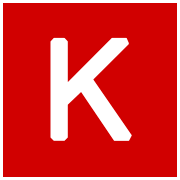

From our work in the previous sections of this notebook I'm sure you can now appreciate that implementing a non-trivial CNN by hand would be a pain, and the looping code above was far from optimized. So we will be using <a href='https://keras.io/'>Keras</a> to quickly construct our neural networks.

The Keras API sits on top of Tensorflow. It allows user to work at a more intuitive level of abstraction where the basic objects are **layers**.

<div id="keras_layers" class='exercise'><b>Layers of a CNN in Keras</b></div></br>
<img src='fig/cnn1.png' width='900px'>

The following is a list of layers commonly used when building CNNs with Keras.<br>
A link to the official documentation for each layer is also provided.

### Input

[**tf.keras.Input**](https://www.tensorflow.org/api_docs/python/tf/keras/Input)(
    shape=None, **kwargs
)

<div style='color:red'><strong>The input is not a layer!</strong></div>

As Pavlos said in lecture, you shouldn't think of the input to your network as a layer. Unfortunately, in Keras, most components of a network are referred to as 'layers'. Someone must have come to their senses because now `Input` can be found in the base `tf.keras` module. While it *can* still be imported from `tf.keras.layers`, we are civilized people and shall speak no more of that.

The network will be expecting input of fixed shape which must be specified with the `shape` parameter. You should look at the data you are using to determine this shape.

Adding an explicit `Input` object to your layer is not required as most layers have an `input_shape` that can be specified if they are the first layer in the network.



### 2D Convolutional Layers

[**keras.layers.Conv2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', data_format='channels_last', 
                    bias_initializer='zeros')

<img src='fig/conv-many-filters.png' width='550px'>

**Some quick review if skipping to this section:**

A convolutional layer is composed of **filters**, which are composed of **kernels** which are themselves composed of **weights**. Each filter also has a bias term though it is often not depicted in diagrams (it is exluded in the one above for example). We learn the weights and biases from our data. Each conv layer also has an associated **activation function** such as ReLU or sigmoid. 

The **number of filters** and the **height and width of the kernels** of which they consist are set by the `filters` and `kernel_size` (a tuple) arguments respectively. 

The **depth of the filters is fixed** by the depth (i.e., 'channels' or 'filter maps') of the input to the conv layer. 

The output of the conv layer is a 3D tensor which is a set of **feature maps**. Each feature map is itself the output of one of the layer's filters convolving on the input. The height and width of the feature map tensor is determined by the input size, `kernel_size`, `padding`, and `stride`. The depth of the output tensor (i.e, number of feature maps) is equal to the number of filters in the layer.
                    
Keras also has a [1D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) used for time series data and a [3D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) used for video.

### Pooling Layers

[**keras.layers.MaxPool2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

<img src='fig/maxpool.png' alt='MaxPool' width='400px'>

Pooling layers are also comprised of filters and feature maps. Let's say the pooling layer has a 2x2 receptive field and a stride of 2. This stride results in feature maps that are one half the size of the input feature maps. We can use a max() operation for each receptive field. 

### Dropout Layers
<img src='fig/dropout.gif' width='200px'>

[**tf.keras.layers.Dropout**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)(rate, seed=None)

Dropout consists in randomly setting a fraction of input units to 0 at each update during training time. In Keras this fraction is set by the `rate` parameter. At inference time, trained weights are multipled by $(1 - \text{rate})$. Dropout often used to help prevent overfitting by limiting the complexity of our model. It can also prevent groups of neurons from 'conspiring' together to have a large affect on the output, something traditional forms of weight regularization would not catch.

**Caution:** Dropout's behavior is not the same if performed after a convolutional layer! [See this post for more information](https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2).

**Q:** Why might it make sense to think of dropout as a type of ensemble method? 🤔

References<br>
[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

### Flatten Layers


[**keras.layers.Flatten**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)()

Like `Input` and `Dropout`, `Flatten` is not a layer in the traditional sense. It has no learned parameters and no parameters other than `input_shape`. Its only function is to flatten its multi-dimensional input into a flat vector. The flatten layer sits between our final 2D output (either from Conv2D or MaxPool2D) and our first fully connected, `Dense` layer.


### Fully Connected Layers.

[**keras.layers.Dense**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)(units, activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros')
<img src='fig/dense.png' width='250px'>

Most CNNs have one or more dense layers at the end with the final layer referred to as the **output layer**. You'll need to specify the number of `units` in each layer (sometimes called 'neurons' or 'nodes') as well as the `activation`. 

*Special care should be taken in deciding on the activation function for the output layer!* The correct choice of activation in this final layer depends on the task we are training our model to perform. For example, a linear activation for regression, but a sigmoid for binary classification.



<div id="keras_model" class='exercise'><b>Defining a Model</b></div></br>

Here our task is building a CNN to (surprise!) classify images as either horses are humans. 🤖-- 🐎 or 🧍?

You be using the [Keras sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to create your CNN model and define its architecture. There are two ways to do this.<br>
You can create a model object using the `Sequential` constructor while:
1. passing it a list of parameterized layers
2. passing no layers and then using the newly created model's `add()` method to attach layers to your model.

We will begin with a very simply CNN. It should consist of the following layers:
- **Input** /w input shape derived below
- **Conv2D** /w 32 filters, 3x3 kernals, default padding & stride, and relu activation
- **MaxPool2D** of size 3x3
- **Conv2D** /w 64 filters, 3x3 kernals, default padding & stride, and relu activation
- **MaxPool2D** of size 3x3
- **Conv2D** /w 128 filters, 3x3 kernals, default padding & stride, and relu activation
- **MaxPool2D** of size 2x2
- **Flatten**
- **Dense** /w 64 units and relu activation
- **Dense** /w 1 **?** units and **?** for an activation


If you find these instructions a bit vague it is because you are being gently nudged to both look at all the helpful **documentation** linked above a think a bit about the task you are giving your network. 😉 

Please continue on until you reach the **end of exercise** note.

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D

We'll need to specify an input shape for our model. We can derive this by looking at one of the images in our dataset.

In [ ]:
image_shape

In [ ]:
# Find input shape
for element in ds_train.take(1).as_numpy_iterator():
    image_shape = element[0].shape
    print(f'The input shape of each batch is: {BATCH_SIZE}')
    print(f'The input shape of each image is: {image_shape}')

In [ ]:
# Construct a CNN
inputs = Input(image_shape)
# x = Conv2D(32, 3, padding='valid', activation="relu")(inputs)
x = Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), padding='valid', 
       activation='relu', use_bias=True, 
       kernel_initializer='glorot_uniform', 
       data_format='channels_last', 
       bias_initializer='zeros')(inputs)

# x = MaxPool2D((3,3))(x)
x = MaxPool2D(pool_size=(3, 3), strides=None, padding='valid', data_format=None)(x)

# x = Conv2D(64, 3, padding='valid', activation="relu")(x)
x = Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), padding='valid', 
       activation='relu', use_bias=True, 
       kernel_initializer='glorot_uniform', 
       data_format='channels_last', 
       bias_initializer='zeros')(x)

# x = MaxPool2D((3,3))(x)
x = MaxPool2D(pool_size=(3, 3), strides=None, padding='valid', data_format=None)(x)

# x = Conv2D(128, 3, padding='valid', activation="relu")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), padding='valid', 
       activation='relu', use_bias=True, 
       kernel_initializer='glorot_uniform', 
       data_format='channels_last', 
       bias_initializer='zeros')(x)

# x = MaxPool2D((3,3))(x)
x = MaxPool2D(pool_size=(3, 3), strides=None, padding='valid', data_format=None)(x)

x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model1 = Model(inputs=inputs, outputs=outputs, name="Model1")

Now let's inspect the model with the `summary()` method. Notice how the dimensions change as the image passes through different stages of the network. Also take note of which layers have the most parameters.

In [ ]:
model1.summary()

**Compiling the Model**

Before we can train our model Keras requires use its `compile()` method to specify a few things:
- An [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) which controls how weights are updated
- A [loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses) which your model is trying to minimize
- A list of [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) (optional) which are other functions that can be monitored during training

The compile method accepts optimizers, losses, and elements of the metrics list as either as objects from their respective Keras modules (imported below) or their names as strings (with underscores replacing spaces).

Compile your model with:
- `optimizer='SGD'`
- `meterics = ['acc']` (e.g., accuracy)
- `loss = `? (think about the task and look at the documentation)

**Note:** Remember that `metrics` is a list.

**Hint:** You can also use Jupyter's `Tab` aoutcomplete on the `losses` module to look at your options.

In [ ]:
from tensorflow.keras import losses, metrics, optimizers

In [ ]:
# compile your model
# your code here
model1.compile(optimizer = 'Adam',
                     loss = 'binary_crossentropy',
                     metrics = ['acc'])

<div id="keras_train" class='exercise'><b>Train the Model</b></div></br>

Train your model by calling its `fit` method. We'll pass in our training data, validation data, and the number of epochs. Note the chaining of methods on the dataset objects!

In [ ]:
history = model1.fit(ds_train.cache()\
                    .shuffle(buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                    .batch(BATCH_SIZE).prefetch(AUTOTUNE),
                    validation_data=ds_test.cache()\
                    .shuffle(buffer_size=ds_test.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                    .batch(BATCH_SIZE).prefetch(AUTOTUNE),
                    epochs=30)

<div class='exercise' id='plottinghistory'><b>Plot the Training History</b></div></br>

In [ ]:
# helper function to avoid repeated code later
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history);

<div id="keras_eval" class='exercise'><b>Evaluate the Model</b></div></br>

Let's see how we did using the model's `evaluate` method.

**Note:** Your model will complain if unless you passing it batches of the same size it saw during training.

In [ ]:
model1.evaluate(ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE))

In [ ]:
model1.evaluate(ds_train.batch(BATCH_SIZE).prefetch(AUTOTUNE))

<div id="" class='exercise'><b>Saving Your Model</b></div></br>

It would be nice if we could save and restore our models between sessions. Here's a few methods!

First, we can save just the learned weights. Careful though! You will have to first reconstruct the same architecture to load these weights into. This also does not save the optimizer state.

In [ ]:
model1.save_weights("data/models/model1_weights.ckpt")

In [ ]:
model1.load_weights("data/models/model1_weights.ckpt");

Alternatively, we can save the entire model, including the architecture itself.

In [ ]:
model1 = model1.save('data/models/model1')

In [ ]:
model1 = keras.models.load_model('data/models/model1')

In [ ]:
# confirm reloading worked
model1.evaluate(ds_train.batch(BATCH_SIZE).prefetch(AUTOTUNE))

<div id="callbacks" class='exercise'><b>Keras Callbacks</b></div></br>

Training CNNs can take a long time. We should checkpoint our model so we don't lose progress and stop early if we don't see improvement to help save on training time. Checkpointing also allows us to recover our best performing version of te model from any point during the training process as later version have a tendency to be overfit.</br>

[Keras Callbacks Documentation](https://keras.io/api/callbacks/)

Unfortunately, subroutines of many callbacks currently result in some [ugly (but harmless) warnings](https://github.com/tensorflow/tensorflow/issues/44178). Until the leves at the Tensorflow workshop put things right we can simply silence them.

In [ ]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Point the keras.models.load() method at the path given below to reload the checkpointed model
mc = ModelCheckpoint('data/models/checkpoints', monitor='val_loss', save_best_only=True, save_weights_only=False)

Callbacks are used by passing them as a list to a model's `fit()` method.<br>
Example: `model.fit(...., callbacks=[es, mc])`

**Note**: If your model trains very quickly then checkpointing may not be worth it. The time it takes to write to disk after each epoch can sometimes take longer than the training itself!

<div id="improving" class='exercise'><b>Exercise: Improving on Baseline Model</b></div></br>

Now see if you can improve on the performance of you previous model. You can try:
- adjusting the architecture
    - more/fewer layers/filters/units
    - adding a dropout(s) layer
- adding data augmentation
    - tweaking the various transformations included
- using callbacks like checkpointing or early stopping
- adjust the number of epochs
- adjust the batch size

**Note:** What follows is not the 'solution,' but merely one way you could reparameterize your model in an attempt to improve the evaluation on the validation set. Can you get below a validation loss of ~3.4?

In [ ]:
from tensorflow.keras.layers import GaussianNoise, BatchNormalization, Activation

In [ ]:
# try and improve on your first CNN
# your code here



# end your code here
model2 = Model(inputs=inputs, outputs=outputs, name="Model2")

In [ ]:
model2.summary()

In [ ]:
model2.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['acc'])

In [ ]:
%%time
# CUSTOMIZE THESE PARAMETERS
BATCH_SIZE2 = 32
history2 = model2.fit(ds_train.cache()\
                    .shuffle(buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                    .map(augment, num_parallel_calls=AUTOTUNE)\
                    .batch(BATCH_SIZE2).prefetch(AUTOTUNE),
                    validation_data=ds_test.cache()\
                    .shuffle(buffer_size=ds_test.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                    .batch(BATCH_SIZE2).prefetch(AUTOTUNE),
                    epochs=50,
                    callbacks=[es],
                    verbose=0)

In [ ]:
plot_loss(history2)

In [ ]:
model2.evaluate(ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE))

In [ ]:
model2.evaluate(ds_train.batch(BATCH_SIZE).prefetch(AUTOTUNE))